## Problem
> There are many seasons that sales are significantly higher or lower than averages. If the company does not know about these seasons, it can lose too much money. Predicting future sales is one of the most crucial plans for a company. Sales forecasting gives an idea to the company for arranging stocks, calculating revenue, and deciding to make a new investment. Another advantage of knowing future sales is that achieving predetermined targets from the beginning of the seasons can have a positive effect on stock prices and investors' perceptions. Also, not reaching the projected target could significantly damage stock prices, conversely. And, it will be a big problem especially for Walmart as a big company.

## Aim
> My aim in this project is to build a model which predicts sales of the stores. With this model, Walmart authorities can decide their future plans which is very important for arranging stocks, calculating revenue and deciding to make new investment or not.

## Step
- 1) EDA
- 2) Modeling, Evaluation

In [1]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import check_numeric
import shap
sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. EDA

In [106]:
def get_data():
    for data in self.datasets:
        df = pd.read_csv(f"{self.file_path}/{data}.csv") 
        df.columns = df.columns.str.lower()
        self.loaded_datasets[data] = df

    # 각각 df 불러오기
    features = self.loaded_datasets['features']
    stores = self.loaded_datasets['stores']
    train = self.loaded_datasets['train']
    df = train.merge(features, on=['store','date','isholiday'], how='left')\
              .merge(stores, on=['store'], how='left')
    
    # columns type change
    df['date'] = pd.to_datetime(df['date'])
    df['isholiday'] = df['isholiday'].astype(int)
    return df

In [107]:
df = get_data()

In [116]:
print(df.shape)
print(df.store.nunique())
print(df.dept.nunique())

(420285, 16)
45
81


In [109]:
df.weekly_sales.describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: weekly_sales, dtype: float64

In [110]:
df = df[df['weekly_sales']>=0]

In [111]:
df.isnull().sum()

store                0
dept                 0
date                 0
weekly_sales         0
isholiday            0
temperature          0
fuel_price           0
markdown1       270085
markdown2       309367
markdown3       283618
markdown4       285750
markdown5       269337
cpi                  0
unemployment         0
type                 0
size                 0
dtype: int64

In [112]:
fill_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
df[fill_cols] = df[fill_cols].fillna(df[fill_cols].mean())

In [113]:
df

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,0,64.88,3.997,4556.610000,20.640000,1.500000,1601.01000,3288.250000,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,0,64.89,3.985,5046.740000,3329.917771,18.820000,2253.43000,2340.010000,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,0,54.47,4.000,1956.280000,3329.917771,7.890000,599.32000,3990.540000,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,0,56.47,3.969,2004.020000,3329.917771,3.180000,437.73000,1537.490000,192.330854,8.667,B,118221


In [123]:
df.groupby(["store"])['weekly_sales'].mean().astype(int).sort_values(ascending=False).head(10)

store
20    29618
4     29175
14    28877
13    27394
2     26956
10    26461
27    24892
6     21958
1     21742
39    21081
Name: weekly_sales, dtype: int64

In [129]:
df.groupby(["type"])['weekly_sales'].mean().astype(int)

type
A    20145
B    12288
C     9547
Name: weekly_sales, dtype: int64

In [133]:
df.groupby(["date"]).size()

date
2010-02-05    2948
2010-02-12    2949
2010-02-19    2971
2010-02-26    2943
2010-03-05    2936
              ... 
2012-09-28    2952
2012-10-05    2967
2012-10-12    2979
2012-10-19    2947
2012-10-26    2951
Length: 143, dtype: int64

## 2. Modeling 

In [37]:
class SalesPredict:

    """
    store 별 판매량 예측
     > trainset: 2010-02-05 ~ 2012-10-26
     > testset: 2012-11-02 ~ 2013-07-26
    """    
    def __init__(self, algo_type):
        self.file_path = "data"        
        self.datasets = ['features', 'stores', 'train', 'test']
        self.test_start_date = '2012-10-01'
        self.loaded_datasets = {}
        self.label_encoder = LabelEncoder()
        self.target_encoder = ce.TargetEncoder(cols=['store'])        
        self.base_model = LGBMRegressor(random_state=42)
        self.algo_type =  algo_type
        self.opt_param = False # True 경우 파라메터 최적화 진행
        self.param_dist = {
            'regressor__n_estimators': np.arange(50, 500, 50),
            'regressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
            'regressor__max_depth': np.arange(3, 10),
            'regressor__subsample': np.arange(0.5, 1.0, 0.1),
            'regressor__colsample_bytree': np.arange(0.5, 1.0, 0.1)
        }    
        
    def load_data(self):
        """
        데이터셋 불러오기
        분리된 데이터셋을 병합
        """
        for data in self.datasets:
            df = pd.read_csv(f"{self.file_path}/{data}.csv") 
            df.columns = df.columns.str.lower()
            self.loaded_datasets[data] = df
        
        # 각각 df 불러오기
        features = self.loaded_datasets['features']
        stores = self.loaded_datasets['stores']
        train = self.loaded_datasets['train'] 
        #test = self.loaded_datasets['test'] # 정답값이 없음
                
        # 병합
        df = train.merge(features, on=['store','date','isholiday'], how='left')\
                  .merge(stores, on=['store'], how='left')
        
        df = df[df['weekly_sales']>=0]
        # columns type change
        df['date'] = pd.to_datetime(df['date'])
        df['isholiday'] = df['isholiday'].astype(int)
        
        # shape check
        assert len(df) == len(train)
        print("total_df_shape:", df.shape)
        return df
    
    
    def add_date_features(self, df):        
        """
        날짜 관련 피처엔지니어링
        """
        df['month'] = df['date'].dt.month
        #df['day'] = df['date'].dt.dayofweek
        #df['dayofweek'] = df['date'].dt.day_name()
        #df["weekend_yn"] = np.where(df["dayofweek"].isin(["Saturday", "Sunday"]), 1, 0)  # 주말여부
        df["dayofyear"] = df['date'].dt.dayofyear  # 연간 일                
        df["week_no"] = df['date'].dt.isocalendar()['week'].astype('int')
        df['week_num'] = np.ceil((df['date'].dt.to_period('M').dt.to_timestamp().dt.weekday + df['date'].dt.day) / 7.0).astype(int)  # 월별주차
        #df = pd.concat([df, pd.get_dummies(data=df['dayofweek'], prefix='dayofweek')], axis=1)  # 요일 one-hot encoding

        # 월별 누적주문수
        # monthly prediction을 위해 YYYY-MM 형태로 변환
        df['date_month'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m'))        
        df['salse_cnt_cum'] = df.groupby(['date_month', 'store', 'dept'])['weekly_sales'].cumsum()        
        return df
    
    
    def add_fe_laggging(self, df, max_lagging_n=14):
        """
        lagging 피처 및 rolling mean 피처 추가
        """
        # 이전 주문수 피처
        for n in np.arange(1, max_lagging_n):
            df[f'ord_cnt_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].shift(n)
            df[f'ord_cnt_cum_d{n}'] = df.groupby(['store', 'dept'])['salse_cnt_cum'].shift(n)
            
        # for n in np.arange(1, max_lagging_n):
        #     df[f'ord_cnt_roll_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].transform(lambda x: x.rolling(n,1).mean())
        #     df[f'ord_cnt_ewm_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].transform(lambda x: x.ewm(span=n, adjust=False).mean())
        return df
    
  
    def add_fe_change_ratio(self, df):
        
        """
        주문수 변동율을 피처로 활용
        """
        df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_d1']-df[f'ord_cnt_d2'])/df[f'ord_cnt_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_d2']-df[f'ord_cnt_d3'])/df[f'ord_cnt_d3']    
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_d4']-df[f'ord_cnt_d5'])/df[f'ord_cnt_d6']        
        # 누적기준
        df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_cum_d1']-df[f'ord_cnt_cum_d2'])/df[f'ord_cnt_cum_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_cum_d2']-df[f'ord_cnt_cum_d3'])/df[f'ord_cnt_cum_d3']        
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_cum_d4']-df[f'ord_cnt_cum_d5'])/df[f'ord_cnt_cum_d6']
        
        return df
    
    
    def _split_data(self, df):        
        """
        특정날짜 기준으로 데이터셋 분리(학습용, 검증용)
        """
        # index를 date로 지정
        if 'date' in df.columns:
            df = df.set_index("date")             
        fill_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
        df[fill_cols] = df[fill_cols].fillna(df[fill_cols].mean())
        df = df.dropna()
            
        # 컬럼제거: leakage 방지
        drop_cols = ['weekly_sales', 'date_month', 'salse_cnt_cum']        
        
        # 최신값까지 누적하여 하나의 날짜에 대해 예측하고 append
        train = df[df.index < self.test_start_date]
        pred = df[df.index >= self.test_start_date]
        print("test_fist_date:", self.test_start_date)
        
        # 학습용 데이터셋
        train['type'] = self.label_encoder.fit_transform(train['type'])
        train['store_enc'] = self.target_encoder.fit_transform(train['store'], train['weekly_sales'])
        X_train = train.drop(drop_cols, axis=1)
        y_train = train[['weekly_sales']]

        # 성능 검증용 데이터셋
        pred['type'] = self.label_encoder.transform(pred['type'])
        pred['store_enc'] = self.target_encoder.transform(pred['store'], pred['weekly_sales'])
        X_pred = pred.drop(drop_cols, axis=1)
        y_pred = pred[['weekly_sales', 'store', 'dept']]  
        
        return X_train, y_train, X_pred, y_pred
        
    
    def fit_predict(self, df):
        """
        데이터셋 분리후 학습, CV, 검증
        """          
        X_train, y_train, X_pred, y_pred = self._split_data(df)                    
        
        if self.algo_type == 'vote_regressor':                              
            lgb_model = self.base_model                                                        
            rf_model = RandomForestRegressor(random_state=42)                        
            vote_model = VotingRegressor([('base', lgb_model), ('rf', rf_model)])                     
            vote_model.fit(X_train, y_train)
            y_pred['pred_cnt'] = vote_model.predict(X_pred).astype(int)
            pred_res = y_pred.copy()   
        
        elif self.algo_type == 'pipeline_cv':            
            pipeline = Pipeline([
                ('scaler', StandardScaler()),                   
                ('feature_selection', SelectKBest(f_regression, k=15)),
                ('regressor', LGBMRegressor())                 
                ])            
            random_search = RandomizedSearchCV(pipeline, param_distributions=self.param_dist, n_iter=10, cv=5, scoring='r2', random_state=42)
            random_search.fit(X_train, y_train)
            print("Best hyperparameters:", random_search.best_params_)
            print("Best R-squared score:", random_search.best_score_)
            best_model = random_search.best_estimator_
            y_pred['pred_cnt'] = best_model.predict(X_pred).astype(int)                         
            pred_res = y_pred.copy()   
        else:
            lgb_model = self.base_model
            lgb_model.fit(X_train, y_train)
            y_pred['pred_cnt'] = lgb_model.predict(X_pred).astype(int)
            pred_res = y_pred.copy()               
        
        # MdAPE
        pred_res['ape'] = 1-(abs(pred_res['weekly_sales']-pred_res['pred_cnt'])/pred_res['weekly_sales'])
        pred_res['gap'] = pred_res['pred_cnt']-pred_res['weekly_sales']
        print("train_shape:", X_train.shape)
        print("test_shape:", X_pred.shape)
        print("MdAPE", pred_res.ape.median())
        print("R2_score", r2_score(pred_res['weekly_sales'], pred_res['pred_cnt']))
        return df, pred_res        
    
    
    def process(self):
        
        df = self.load_data()
        df = self.add_date_features(df)
        df = self.add_fe_laggging(df)
        #df = self.add_fe_change_ratio(df)        
        df, pred_res = self.fit_predict(df)
        
        return df, pred_res

In [ ]:
# algo_type = ['pipeline_cv', 'vote_regressor', 'base']

In [39]:
# base model
self = SalesPredict('base')
df, pred_res  = self.process()

total_df_shape: (421570, 16)
test_fist_date: 2012-10-01
train_shape: (367981, 45)
test_shape: (11839, 45)
MdAPE 0.902997623786914
R2_score 0.9863775441729136


In [40]:
pred_res.head()

,weekly_sales,store,dept,pred_cnt,ape
date,,,,,
2012-10-05,21904.47,1,1,20006,0.913330
2012-10-12,22764.01,1,1,21844,0.959585
2012-10-19,24185.27,1,1,22939,0.948470
2012-10-26,27390.81,1,1,23983,0.875586
2012-10-05,48577.08,1,2,47526,0.978363


In [28]:
self = SalesPredict('pipeline_cv') 

In [29]:
df, pred_res  = self.process()

total_df_shape: (421570, 16)
test_fist_date: 2012-10-01
Best hyperparameters: {'regressor__subsample': 0.7, 'regressor__n_estimators': 350, 'regressor__max_depth': 8, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.7}
Best R-squared score: 0.947900610643579
train_shape: (367981, 45)
test_shape: (11839, 45)
MdAPE 0.9059566348369907
R2_score 0.9853976074021346


## 3. Evaluation

In [41]:
pred_res

,weekly_sales,store,dept,pred_cnt,ape
date,,,,,
2012-10-05,21904.47,1,1,20006,0.913330
2012-10-12,22764.01,1,1,21844,0.959585
2012-10-19,24185.27,1,1,22939,0.948470
2012-10-26,27390.81,1,1,23983,0.875586
2012-10-05,48577.08,1,2,47526,0.978363
...,...,...,...,...,...
2012-10-26,6817.48,45,97,5694,0.835206
2012-10-05,628.10,45,98,484,0.770578
2012-10-12,1061.02,45,98,801,0.754934


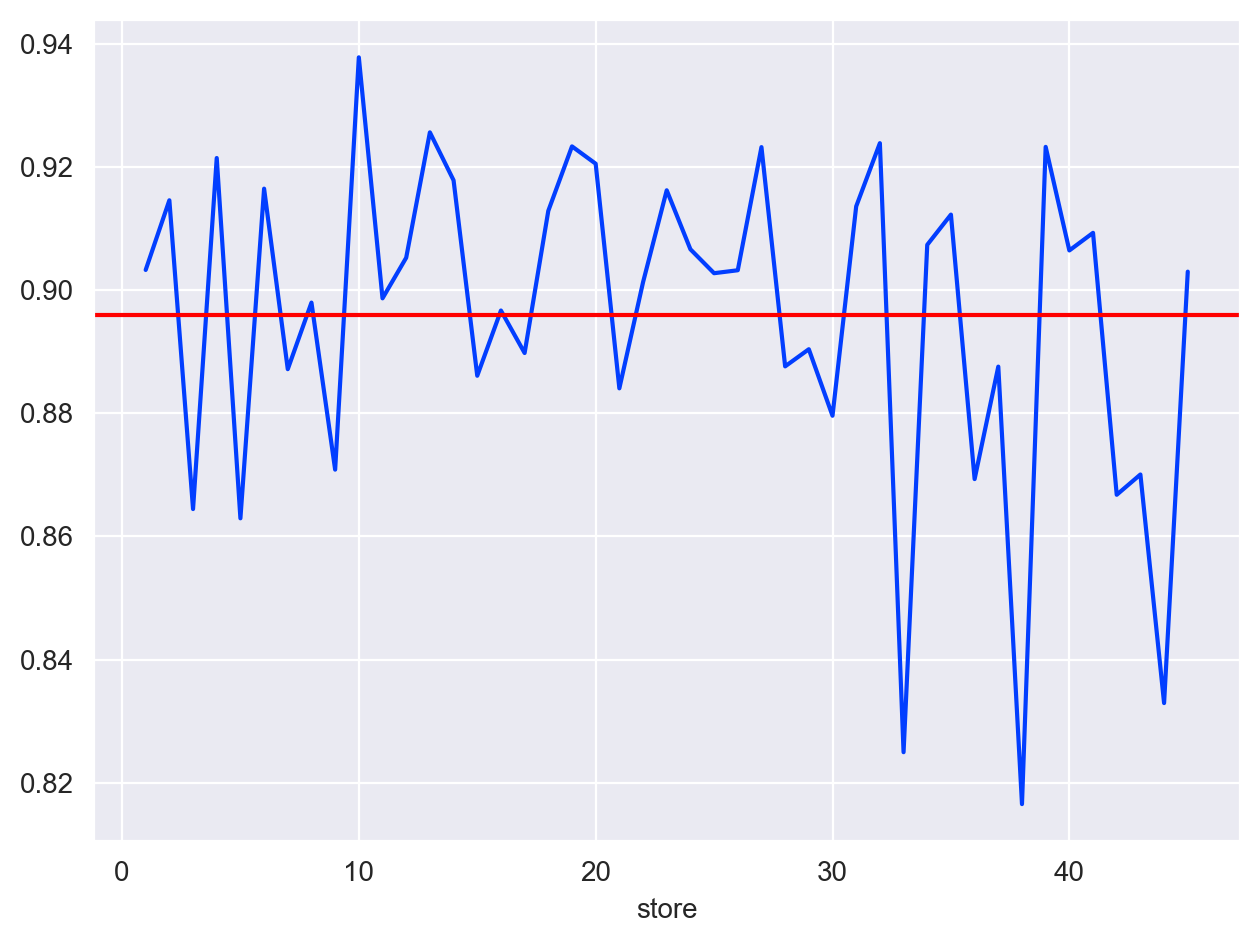

In [87]:
pred_res.groupby('store').ape.median().plot()
plt.axhline(y = pred_res.groupby('store').ape.median().mean(), color = 'r', linestyle = '-')
plt.tight_layout()

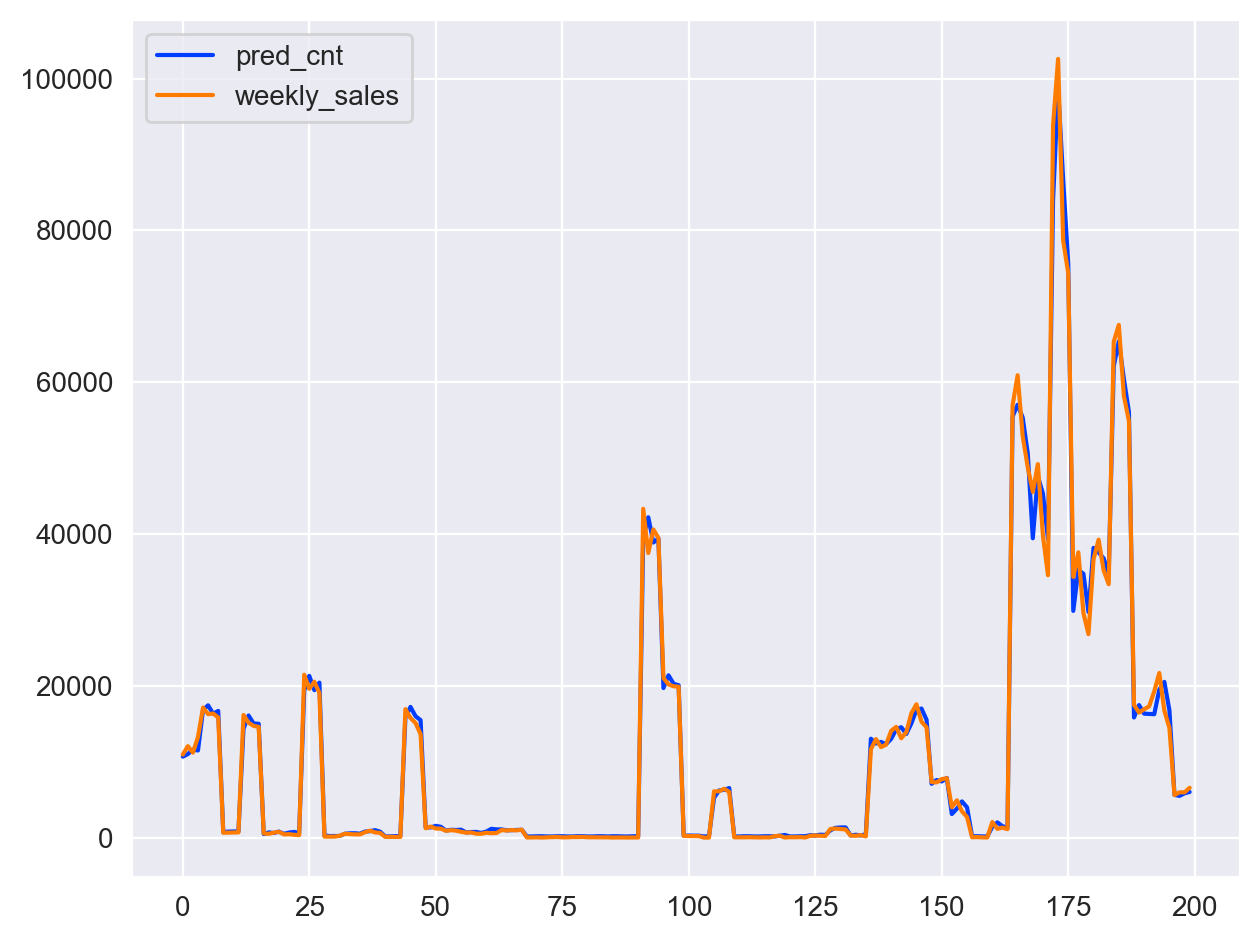

In [88]:
pred_res.query("store == 42").reset_index()[['pred_cnt', 'weekly_sales']].plot()
plt.tight_layout()

In [47]:
def _check_feature_importance(df):        
    """
    shap value 확인
    """        
    # index를 date로 지정
    if 'date' in df.columns:
        df = df.set_index("date")             
    fill_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
    df[fill_cols] = df[fill_cols].fillna(df[fill_cols].mean())
    df = df.dropna()

    # 컬럼제거: leakage 방지
    drop_cols = ['weekly_sales', 'date_month', 'salse_cnt_cum']        

    # shap value check
    train = df[df.index < self.test_start_date]
    pred = df[df.index >= self.test_start_date]

    train['type'] = self.label_encoder.fit_transform(train['type'])
    train['store_enc'] = self.target_encoder.fit_transform(train['store'], train['weekly_sales'])
    X_train = train.drop(drop_cols, axis=1)
    y_train = train[['weekly_sales']]

    # 성능 체크 용도
    pred['type'] = self.label_encoder.transform(pred['type'])
    pred['store_enc'] = self.target_encoder.transform(pred['store'], pred['weekly_sales'])
    X_pred = pred.drop(drop_cols, axis=1)
    y_pred = pred[['weekly_sales', 'store', 'dept']] 

    model = self.base_model
    model.fit(X_train, y_train)
    y_pred['pred_cnt'] = model.predict(X_pred).astype(int)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_pred)        
    shap.summary_plot(shap_values, X_pred)

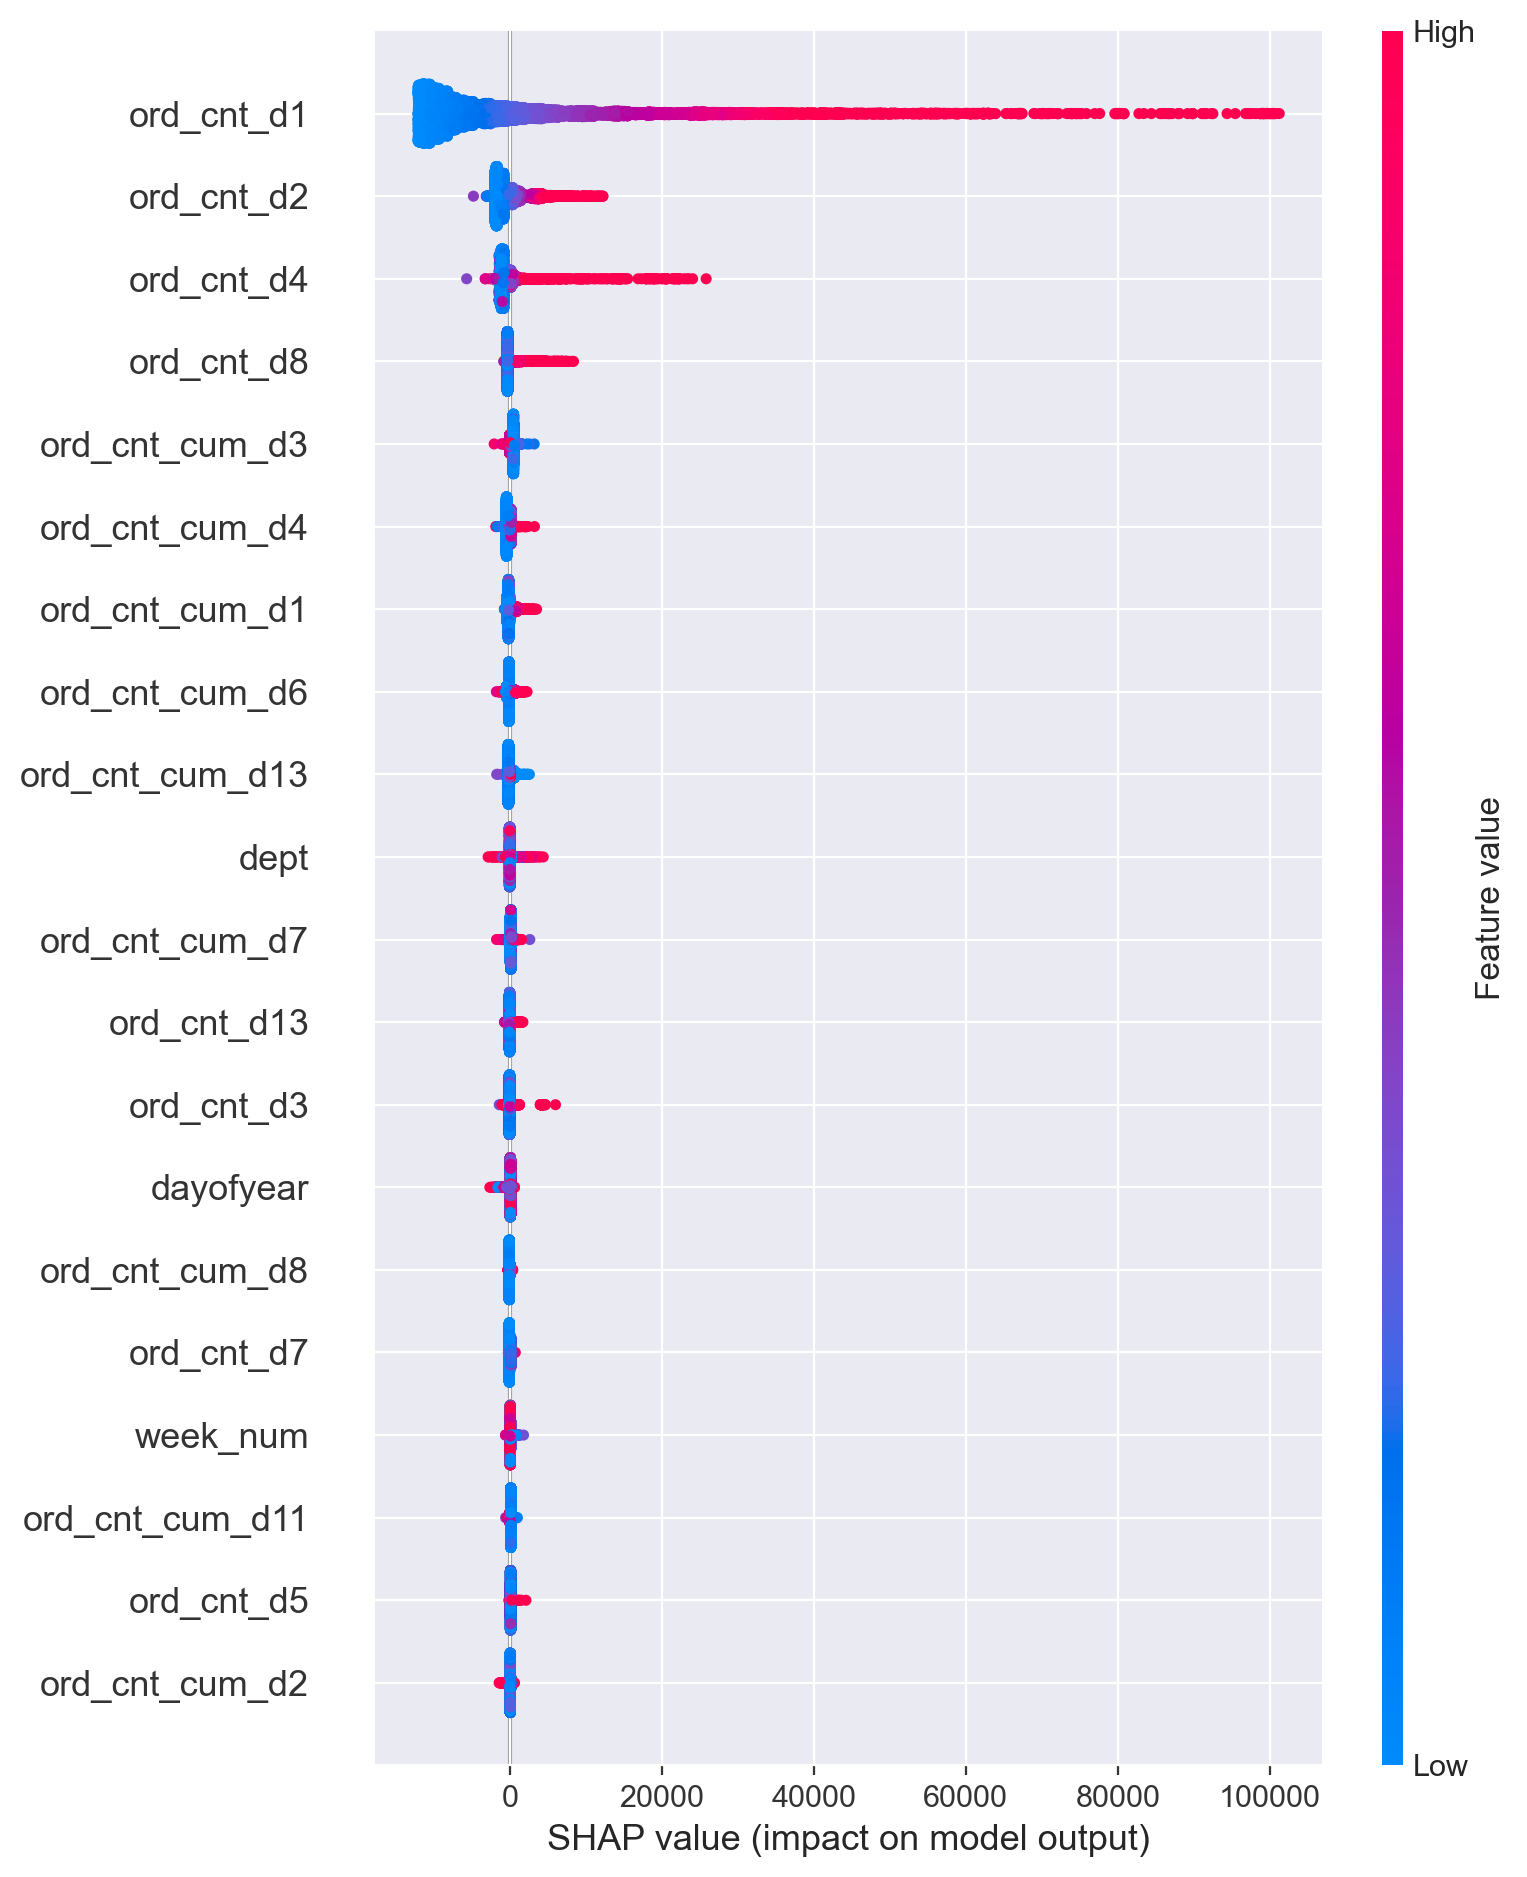

In [48]:
_check_feature_importance(df)

In [81]:
pred_res.groupby("store").ape.median().sort_values(ascending=False).head(20)#.plot(kind='bar')

store
10    0.937800
13    0.925618
32    0.923860
19    0.923340
39    0.923259
27    0.923220
4     0.921450
20    0.920527
14    0.917834
6     0.916476
23    0.916213
2     0.914586
31    0.913600
18    0.912874
35    0.912262
41    0.909301
34    0.907358
24    0.906635
40    0.906441
12    0.905264
Name: ape, dtype: float64

In [68]:
pred_res['gap'] = pred_res['pred_cnt']-pred_res['weekly_sales']

In [76]:
store_list = pred_res.groupby("store").ape.median().sort_values(ascending=False).head(10).index

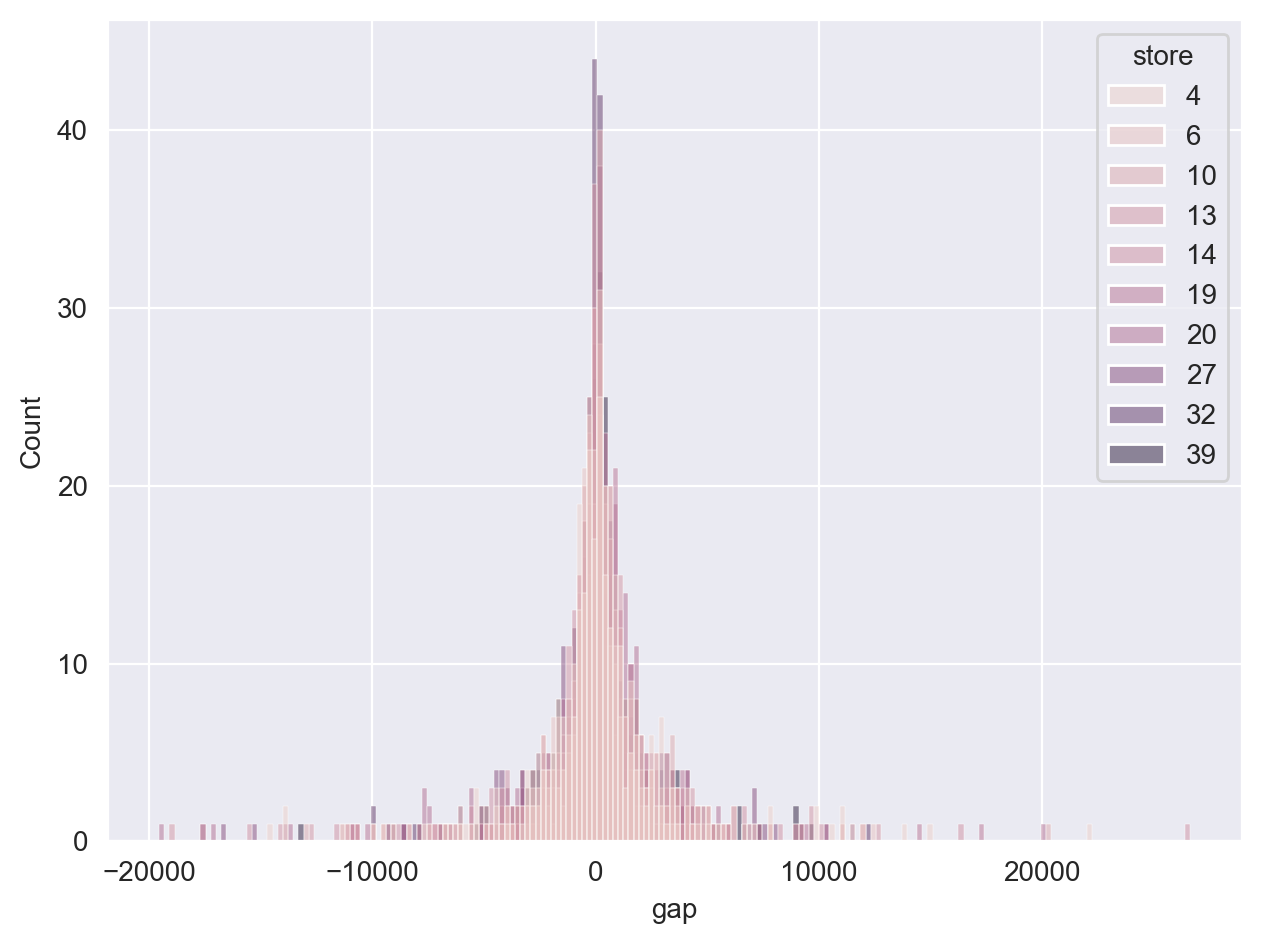

In [78]:
sns.histplot(x="gap", hue="store", data=pred_res[pred_res['store'].isin(store_list)])
plt.tight_layout()

In [79]:
low_store_list = pred_res.groupby("store").ape.median().sort_values(ascending=False).tail(10).index

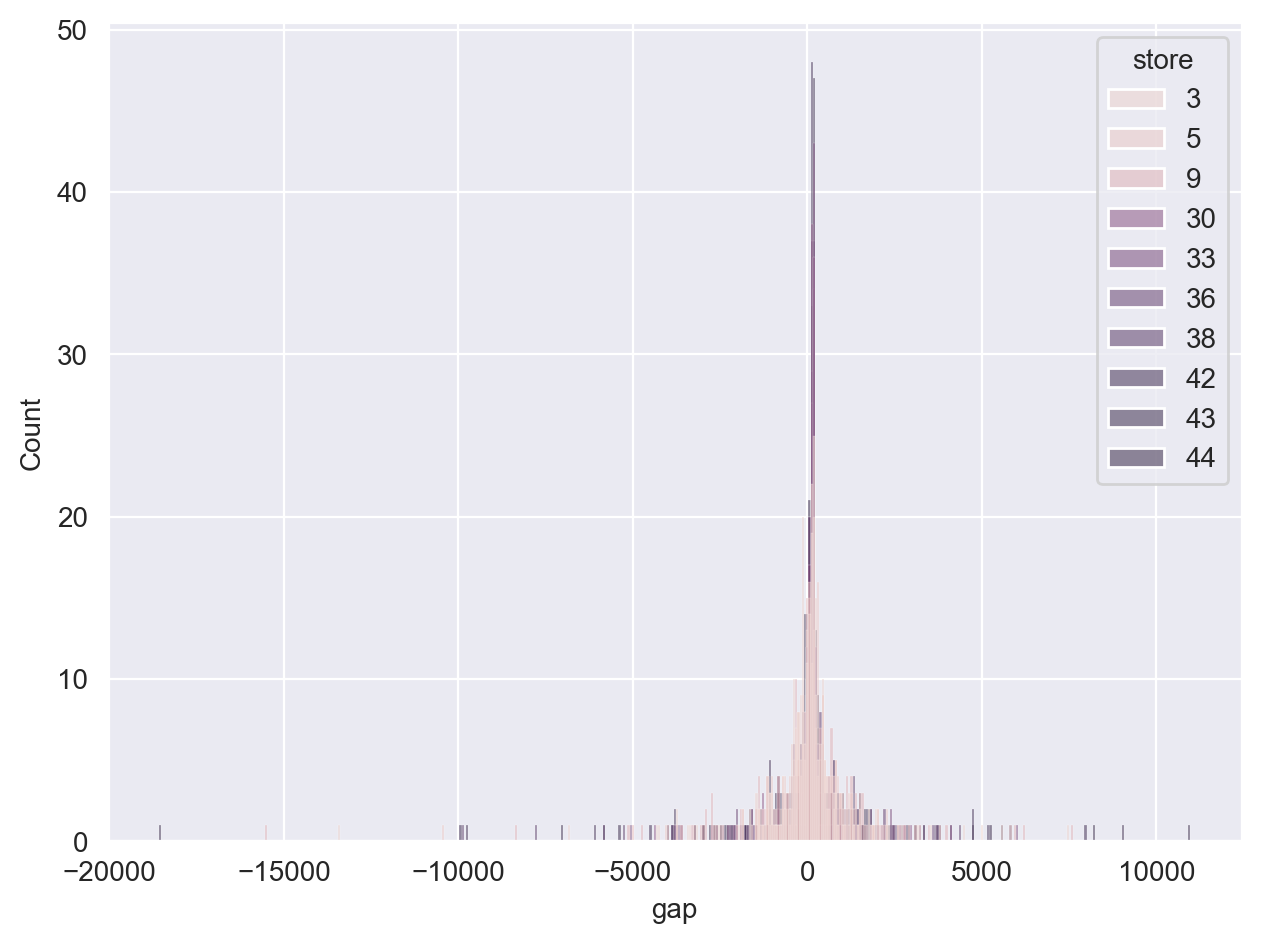

In [80]:
sns.histplot(x="gap", hue="store", data=pred_res[pred_res['store'].isin(low_store_list)])
plt.tight_layout()